**Practical introduction to Machine Learning**
**Practical Session 3 Classification**

A rendre le 06/11

The goal of this practical session is to understand and apply different machine learning methods studied during the course. Using Python and Jupyter Notebook, we trained and compared several models on two datasets: the Pima dataset (for predicting diabetes) and the Digits dataset.

We used different algorithms such as LDA, Logistic Regression, SVC, and MLPClassifier, and evaluated their performance using metrics like accuracy and AUC. The objective was to see which model performs best and to understand why.

In the second part, we analyzed the errors made by the models and tested their robustness by adding noise to the data. Finally, we implemented a Convolutional Neural Network (CNN) using PyTorch to see if it performs better and if it is more robust to noise compared to the other models.

This report summarizes the steps, results, and interpretations obtained during the session.

In [1]:
import numpy as np
import pylab as pl
import scipy as sp
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import roc_auc_score, make_scorer, accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import warnings
warnings.filterwarnings('ignore')

**1.3 Loading the data**

In [2]:
digits = np.load("/Users/alexisbezacier/Desktop/M2DS/Remy/Lab3/digits.npz")
pima = np.load("/Users/alexisbezacier/Desktop/M2DS/Remy/Lab3/pima.npz")

In [3]:
print(pima)

NpzFile '/Users/alexisbezacier/Desktop/M2DS/Remy/Lab3/pima.npz' with keys: xall, yall, varnames


**Question 1**

In [4]:
x1 = pima['xall']
y1 = pima['yall']
varnames = pima['varnames']

x2_train = digits['x']/255
xt2 = digits['xt']/255
y2_train = digits['y']
yt2 = digits['yt']


In [5]:
n_diabetics = np.sum(y1 == 1)
print(n_diabetics)

n_negatives = np.sum(y1 == -1)
print(n_negatives)

242
467


The dataset is not well balance. So the F1 score is a really important metric that we ave to consider. In fact, If a model predict non diabetics every time, it will still have 66% accuracy.

**Question 2**

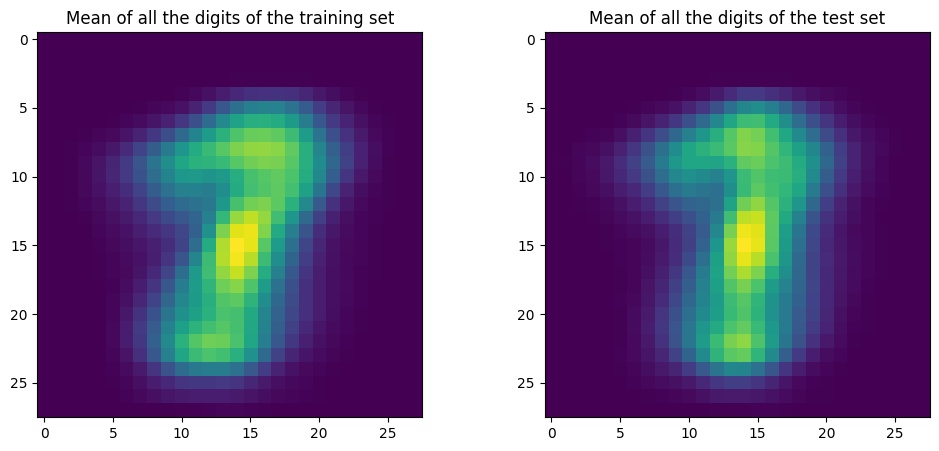

In [6]:
pl.figure(figsize=(12,5))


mean_digits_x = x2_train.mean(axis=0).reshape(28,28)
mean_digits_y = xt2.mean(axis=0).reshape(28,28)

pl.subplot(1,2,1)
pl.title('Mean of all the digits of the training set')
pl.imshow(mean_digits_x)

pl.subplot(1,2,2)
pl.title('Mean of all the digits of the test set')
pl.imshow(mean_digits_y)



Here, we plot the mean respectively of all the images of the training and test set. The two images plotted are real image of the dataset unless by luck, one of them exactly correspond to the mean calculated.

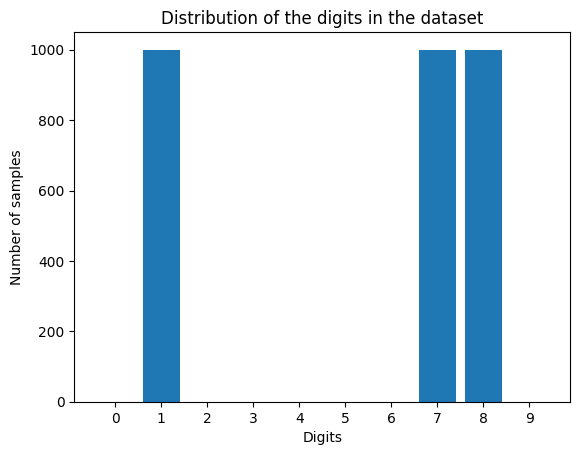

In [7]:
pl.hist(y2_train, bins=np.arange(11) - 0.5, rwidth=0.8)
pl.xticks(range(10))
pl.title("Distribution of the digits in the dataset")
pl.xlabel("Digits")
pl.ylabel("Number of samples")
pl.show()

The 3 classes are equally represented which is good for the next steps. Because if it was not the case, the model could give more attention to the class more represented which could lead to overfitting.

In [8]:
print(varnames)

['Pregnancies' 'Glucose' 'BloodPressure' 'SkinThickness' 'Insulin' 'BMI'
 'DiabetesPedigreeFunction' 'Age']


In [9]:
mean_pima = x1.mean(axis=0)

for i, mean in enumerate(mean_pima):
    print(f"mean_{varnames[i]}={mean}")


mean_Pregnancies=3.7475317348378
mean_Glucose=121.60789844851904
mean_BloodPressure=69.64315937940762
mean_SkinThickness=20.76586741889986
mean_Insulin=80.53173483779972
mean_BMI=32.45303244005642
mean_DiabetesPedigreeFunction=0.4709605077574047
mean_Age=33.02115655853314


Here, there are a lot of things to say:

- The means are not in the same units. In fact, mean_Pregnancies is a count, while mean_BloodPressure is measured in mmHg, mean_Glucose in mg/dL, mean_BMI in kg/m², and so on.

- On average, a patient has had around 4 pregnancies and is 33 years old.

- The mean BMI is 32.45, placing the average patient in the obese category, while the average glucose level is 121.6 mg/dL, slightly elevated.

https://www.heartfoundation.org.au/bmi-calculator
https://www.ynhhs.org/articles/what-is-healthy-blood-sugar

- Blood pressure, skin thickness, and insulin levels are moderate, and the Diabetes Pedigree Function average of 0.47 indicates an intermediate familial risk of diabetes.

https://dergipark.org.tr/en/download/article-file/1970853#:~:text=The%20

**2 Predicting Diabetes on the Pima dataset**

**2.1 Know the data**

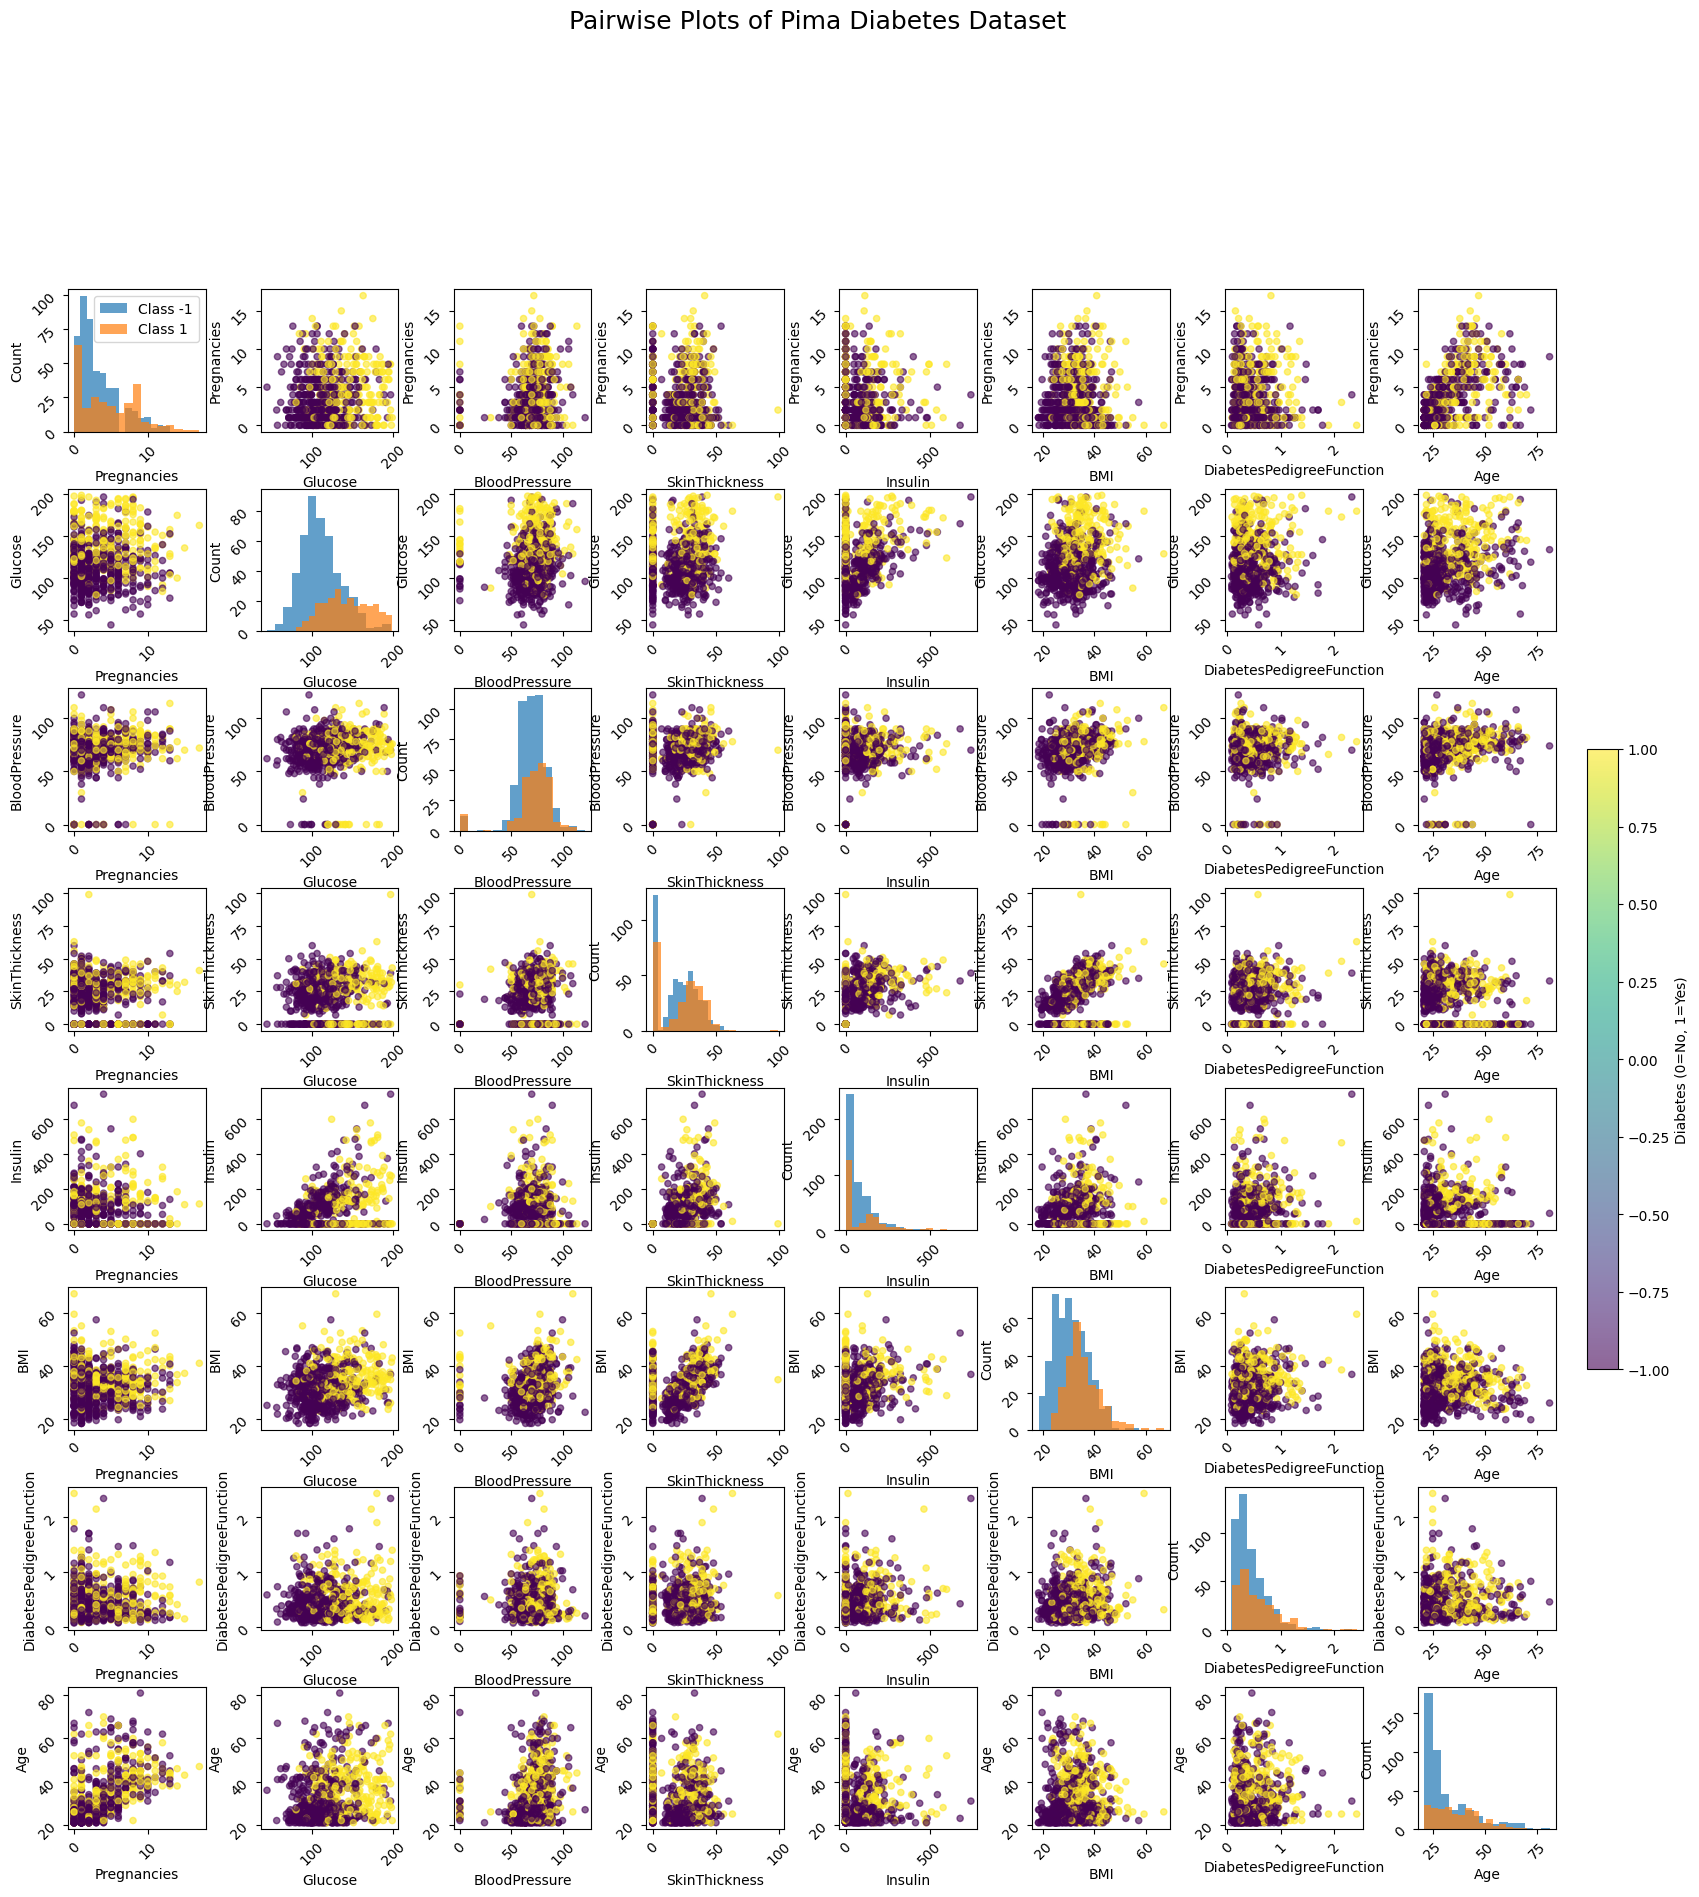

In [10]:
n_vars = len(varnames)
fig, axes = pl.subplots(n_vars, n_vars, figsize=(20, 20))
pl.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(n_vars):
    for j in range(n_vars):
        ax = axes[i, j]
        
        if i == j:
            for class_val in np.unique(y1):
                ax.hist(x1[y1 == class_val, i], alpha=0.7, label=f'Class {int(class_val)}', bins=15)
            ax.set_xlabel(varnames[i])
            ax.set_ylabel('Count')
            if i == 0:  
                ax.legend()
        else:
            scatter = ax.scatter(x1[:, j], x1[:, i], c=y1, cmap='viridis', alpha=0.6, s=20)
            ax.set_xlabel(varnames[j])
            ax.set_ylabel(varnames[i])

        ax.tick_params(axis='x', rotation=45)
        ax.tick_params(axis='y', rotation=45)

cbar = fig.colorbar(scatter, ax=axes, orientation='vertical', fraction=0.02, pad=0.02)
cbar.set_label('Diabetes (0=No, 1=Yes)')

pl.suptitle('Pairwise Plots of Pima Diabetes Dataset', fontsize=18, y=1.02)
pl.show()

We notice that there is a clearer separation between diabetics and non-diabetics for the variable Glucose. In fact, the points are more separated than for all the other variables, which is reassuring according to our knowledge. The second one is BMI, which shows that BMI tends to be higher for diabetic patients, especially when we look at the scatter plot of Glucose versus BMI. The third one is Age, we notice a significant separation between the two groups, which is very interesting to take into account.

The less informative variables are SkinThickness and Insulin, which have a very similar distribution for both groups. DiabetesPedigreeFunction and Pregnancies are also less discriminative, even though we know that type 2 diabetes often appears in women who have been pregnant. As I mentioned before, the fact that insulin is not a clearer feature is intriguing to me, since it is an important factor in diabetes.

In [11]:
x1_train = x1[:300]
x1_test = x1[300:]

In [12]:
mean_train = np.mean(x1_train, axis=0)
var_train = np.var(x1_train, axis=0)
min_train = np.min(x1_train, axis=0)
max_train = np.max(x1_train, axis=0)


mean_test = np.mean(x1_test, axis=0)
var_test = np.var(x1_test, axis=0)
min_test = np.min(x1_test, axis=0)
max_test = np.max(x1_test, axis=0)


train_stats = pd.DataFrame({
    'Feature': varnames,
    'Mean': mean_train,
    'Variance': var_train,
    'Min': min_train,
    'Max': max_train
})

test_stats = pd.DataFrame({
    'Feature': varnames,
    'Mean': mean_test,
    'Variance': var_test,
    'Min': min_test,
    'Max': max_test
})

print("Train Set")
print(train_stats)

print("Test Set")
print(test_stats)

Train Set
                    Feature        Mean      Variance     Min      Max
0               Pregnancies    3.860000     11.053733   0.000   17.000
1                   Glucose  122.350000    901.100833  44.000  197.000
2             BloodPressure   69.183333    320.163056   0.000  122.000
3             SkinThickness   20.176667    245.038789   0.000   60.000
4                   Insulin   78.716667  13478.709722   0.000  744.000
5                       BMI   32.666667     53.131022  18.400   67.100
6  DiabetesPedigreeFunction    0.475570      0.108449   0.078    2.329
7                       Age   32.580000    117.623600  21.000   69.000
Test Set
                    Feature        Mean      Variance     Min     Max
0               Pregnancies    3.665037     11.181198   0.000   14.00
1                   Glucose  121.063570    947.663441  56.000  199.00
2             BloodPressure   69.980440    334.234336   0.000  114.00
3             SkinThickness   21.198044    257.425326   0.000 

Let's look at the variance and scaling values for each feature in the training dataset. We notice a very high variance for Insulin, whereas the values for DiabetesPedigreeFunction are very low. This indicates that the features have very different scales and variances. Features like Insulin and Glucose have much higher variance than others, which could bias models that are sensitive to feature scaling as Regression, SVM, MLP, PCA. Models such as decision trees, however, are generally not affected by feature scaling.

In [13]:
scaler = StandardScaler()

train_scaled = scaler.fit_transform(x1_train)

test_scaled = scaler.transform(x1_test)

In [14]:
print(train_scaled[:5])
print(test_scaled[:5])

[[ 0.9444417   1.22092021 -0.28968335 -1.28893792 -0.67802005 -0.72253975
  -0.55135606  0.68415841]
 [-1.16100159  1.9204925  -0.17790842  1.20248347 -0.67802005  1.2804502
   4.30417257 -0.69891115]
 [-0.86022397  0.78785165 -0.73678305 -1.28893792 -0.67802005 -0.40700024
   0.26852683 -0.3300926 ]
 [-0.55944636 -1.71062082  0.04564143  0.43589227 -0.67802005 -0.6402251
   0.3353321  -0.97552507]
 [ 0.9444417  -0.6446059  -0.17790842  0.75530527 -0.67802005  0.88259603
  -0.39952589 -0.14568333]]
[[-0.25866875 -2.04375048  0.71629098  0.49977487 -0.67802005  0.23779789
  -0.70622282  1.23738624]
 [-0.86022397 -1.07767446 -0.40145827 -0.52234672 -0.3076428  -0.74997797
   0.31711248 -0.79111579]
 [-0.25866875 -1.07767446  0.49274113 -1.28893792 -0.67802005  1.37648396
   0.25334381 -1.06772971]
 [ 1.54599693  1.42079801  1.05161575 -1.28893792 -0.67802005 -0.31096648
  -0.52706323  1.51400015]
 [-0.86022397  0.08827936 -1.07210782  1.26636607  0.76042181  0.08688769
   1.47709493 -0.4

In [15]:
mean_train = np.mean(train_scaled, axis=0)
var_train = np.var(train_scaled, axis=0)
min_train = np.min(train_scaled, axis=0)
max_train = np.max(train_scaled, axis=0)


mean_test = np.mean(test_scaled, axis=0)
var_test = np.var(test_scaled, axis=0)
min_test = np.min(test_scaled, axis=0)
max_test = np.max(test_scaled, axis=0)


train_stats = pd.DataFrame({
    'Feature': varnames,
    'Mean': mean_train,
    'Variance': var_train,
    'Min': min_train,
    'Max': max_train
})

test_stats = pd.DataFrame({
    'Feature': varnames,
    'Mean': mean_test,
    'Variance': var_test,
    'Min': min_test,
    'Max': max_test
})

print("Train Set")
print(train_stats)

print("Test Set")
print(test_stats)

Train Set
                    Feature          Mean  Variance       Min       Max
0               Pregnancies  5.329071e-17       1.0 -1.161002  3.952218
1                   Glucose  2.013204e-16       1.0 -2.610071  2.486813
2             BloodPressure -2.072416e-16       1.0 -3.866481  2.951789
3             SkinThickness  6.513308e-17       1.0 -1.288938  2.544018
4                   Insulin -2.368476e-17       1.0 -0.678020  5.730368
5                       BMI  3.227048e-16       1.0 -1.957260  4.723947
6  DiabetesPedigreeFunction  2.072416e-17       1.0 -1.207262  5.628132
7                       Age  1.569115e-16       1.0 -1.067730  3.358093
Test Set
                    Feature      Mean  Variance       Min       Max
0               Pregnancies -0.058641  1.011531 -1.161002  3.049885
1                   Glucose -0.042855  1.051673 -2.210315  2.553439
2             BloodPressure  0.044548  1.043950 -3.866481  2.504690
3             SkinThickness  0.065248  1.050549 -1.288938  5.

**2.2 Bayesian decision and linear classification**

In [16]:
y1_train = y1[:300]
y1_test = y1[300:]

In [17]:
model = LinearDiscriminantAnalysis()
model.fit(train_scaled, y1_train)

y_prob = model.predict_proba(test_scaled)[:, 1]
y_pred = model.predict(test_scaled)

auc_LDA = roc_auc_score(y1_test, y_prob)
acc_LDA = accuracy_score(y1_test, y_pred)
f1_LDA = f1_score(y1_test, y_pred)
print(f"LDA ROC AUC: {auc_LDA:.3f}")
print(f"LDA Accuracy: {acc_LDA:.3f}")
print(f"LDA F1-score: {f1_LDA:.3f}")


LDA ROC AUC: 0.864
LDA Accuracy: 0.795
LDA F1-score: 0.638


In [61]:
lda = LinearDiscriminantAnalysis(solver='lsqr')

param_grid = {
    'shrinkage': [None, 'auto', 0.1, 0.3, 0.5, 0.7, 0.9]
}

grid1 = GridSearchCV(
    estimator=lda,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5  
)

grid1.fit(train_scaled, y1_train)

best_lda = grid1.best_estimator_
y_pred = best_lda.predict(test_scaled)
y_proba = best_lda.predict_proba(test_scaled)[:,1]

acc = accuracy_score(y1_test, y_pred)
auc_test = roc_auc_score(y1_test, y_proba)
F1 = f1_score(y1_test,y_pred)

print("Best shrinkage:", grid1.best_params_)
print("Best ROC AUC (CV):", grid1.best_score_)
print("Accuracy on test set:", acc)
print("ROC AUC on test set:", auc_test)
print("F1 Score", F1)

Best shrinkage: {'shrinkage': 0.5}
Best ROC AUC (CV): 0.8043062200956939
Accuracy on test set: 0.8141809290953546
ROC AUC on test set: 0.869762608029756
F1 Score 0.6859504132231405


We performed a GridSearchCV to find the best value for the shrinkage parameter in LDA. The result shows that the best shrinkage is 0.5, which means that a regularization is needed for the model to perform better. This suggests that the covariance estimation is unstable for this dataset.

When we evaluate the model on the test set, we get a ROC AUC of 0.869, indicating that the model can distinguish well between diabetic and non-diabetic patients.

Overall, the LDA model performs well with shrinkage, and linear assumptions seem not to be sufficient for this dataset.

In [19]:
qda = QuadraticDiscriminantAnalysis()  
qda.fit(train_scaled, y1_train)


QuadraticDiscriminantAnalysis()

In [20]:
y_pred = qda.predict(test_scaled)
y_prob = qda.predict_proba(test_scaled)[:, 1]
auc_QDA = roc_auc_score(y1_test, y_prob)
acc_QDA = accuracy_score(y1_test, y_pred)
f1_QDA = f1_score(y1_test, y_pred)

print(f"QDA ROC AUC: {auc_QDA:.3f}")
print(f"QDA Accuracy: {acc_QDA:.3f}")
print(f"QDA F1-score: {f1_QDA:.3f}")


QDA ROC AUC: 0.811
QDA Accuracy: 0.760
QDA F1-score: 0.608


We trained a Quadratic Discriminant Analysis (QDA) classifier on the same dataset. The results show that QDA achieves an accuracy of 0.76 and a ROC AUC of 0.81 on the test set. In comparison, LDA had a higher ROC AUC of 0.86, indicating better discrimination between diabetic and non-diabetic patients.

This means that, even if the covariance matrix is not exactly the same for each class, using QDA does not improve accuracy. LDA, with its linear assumption and shared covariance, appears to be sufficient and more stable for this problem.

In [21]:
qda = QuadraticDiscriminantAnalysis()


param_grid = {
    'reg_param': [0.0, 0.1, 0.2, 0.3, 0.5, 0.7, 0.9]
}

grid = GridSearchCV(estimator=qda, param_grid=param_grid, scoring='roc_auc', cv=5)
grid.fit(train_scaled, y1_train)


print("Best reg_param:", grid.best_params_)
print("Best ROC AUC (CV):", grid.best_score_)

y_prob_test = grid.best_estimator_.predict_proba(test_scaled)[:, 1]
roc_auc_test = roc_auc_score(y1_test, y_prob_test)
print("ROC AUC on test set:", roc_auc_test)

Best reg_param: {'reg_param': 0.9}
Best ROC AUC (CV): 0.8047846889952153
ROC AUC on test set: 0.8604911935236845


We performed cross-validation to tune the reg_param of the Quadratic Discriminant Analysis (QDA) model. The best value found was 0.9, indicating that a high level of regularization is beneficial for this dataset.

Overall, QDA performs slightly worse than LDA, suggesting that the additional flexibility of QDA does not provide improvement for this dataset. 
-> Regularization is important to stabilize the covariance estimates in QDA.

In [22]:
gnb = GaussianNB()
gnb.fit(train_scaled, y1_train)
y_pred = gnb.predict(test_scaled)
y_prob = gnb.predict_proba(test_scaled)[:, 1]

acc_gnb = accuracy_score(y1_test, y_pred)
auc_gnb = roc_auc_score(y1_test, y_prob)
f1_gnb = f1_score(y1_test, y_pred)

print(f"GaussianNB Accuracy: {acc_gnb:.3f}")
print(f"GaussianNB ROC AUC: {auc_gnb:.3f}")
print(f"GaussianNB F1-score: {f1_gnb:.3f}")

GaussianNB Accuracy: 0.768
GaussianNB ROC AUC: 0.831
GaussianNB F1-score: 0.652


We trained a Gaussian Naive Bayes (GNB) classifier on the train dataset. The model achieves an accuracy of 0.768 and a ROC AUC of 0.831 on the test set. Compared to LDA and QDA, GaussianNB performs better than QDA but worse than LDA in terms of ROC AUC. This shows that, although the independence assumption of GaussianNB is not fully efficient in this case, the model still provides reasonable discrimination between diabetic and non-diabetic patients. LDA remains the most effective model for this dataset.

In [23]:
logreg = LogisticRegression() 
logreg.fit(train_scaled, y1_train)
y_pred = logreg.predict(test_scaled)


y_prob = logreg.predict_proba(test_scaled)[:, 1]

acc_logreg = accuracy_score(y1_test, y_pred)
auc_logreg = roc_auc_score(y1_test, y_prob)
f1_logreg = f1_score(y1_test, y_pred)

print(f"Logistic Regression Accuracy: {acc_logreg:.3f}")
print(f"Logistic Regression ROC AUC: {auc_logreg:.3f}")
print(f"Logistic Regression F1-score: {f1_logreg:.3f}")

Logistic Regression Accuracy: 0.795
Logistic Regression ROC AUC: 0.865
Logistic Regression F1-score: 0.638


We trained a Logistic Regression model on our dataset. On the test set, it got an accuracy of 0.795, a ROC AUC of 0.865, and an F1-score of 0.638.

When we compare it to the other models, Logistic Regression did a bit better than LDA in accuracy and was about the same in ROC AUC. It also did better than QDA and GaussianNB. This shows that a linear decision boundary works pretty well for separating diabetic and non-diabetic patients in our dataset.

In [58]:
logreg_l1 = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)
param_grid = {'C': np.logspace(-3, 2, 10)}

grid = GridSearchCV(logreg_l1, param_grid, scoring='roc_auc', cv=5)
grid.fit(train_scaled, y1_train)

best_logreg_l1 = grid.best_estimator_

y_pred_test = best_logreg_l1.predict(test_scaled)
y_prob_test = best_logreg_l1.predict_proba(test_scaled)[:, 1]

acc = accuracy_score(y1_test, y_pred_test)
f1 = f1_score(y1_test, y_pred_test)
roc_auc = roc_auc_score(y1_test, y_prob_test)

print("Best C:", grid.best_params_)
print(f"Tuned Log Reg Accuracy on test set: {acc:.3f}")
print(f"Tuned Log Reg F1 Score on test set: {f1:.3f}")
print(f"Tuned Log Reg ROC AUC on test set: {roc_auc:.3f}")


Best C: {'C': 0.5994842503189409}
Tuned Log Reg Accuracy on test set: 0.800
Tuned Log Reg F1 Score on test set: 0.650
Tuned Log Reg ROC AUC on test set: 0.866


It’s kind of interesting because the GridSearch picked a C value of 0.599, which means the model has some regularization. The coefficients are a bit shrunk, but not all the way to zero.

The tuned L1-Regression is performing very well. It's the second best model for instance behind the tuned LDA.

[ 0.41792371  0.92443537 -0.06030404 -0.12756527 -0.24485343  0.68386538
  0.46644474  0.        ]
Variables removed: ['Age']
Variables kept: ['Pregnancies' 'Glucose' 'BloodPressure' 'SkinThickness' 'Insulin' 'BMI'
 'DiabetesPedigreeFunction']


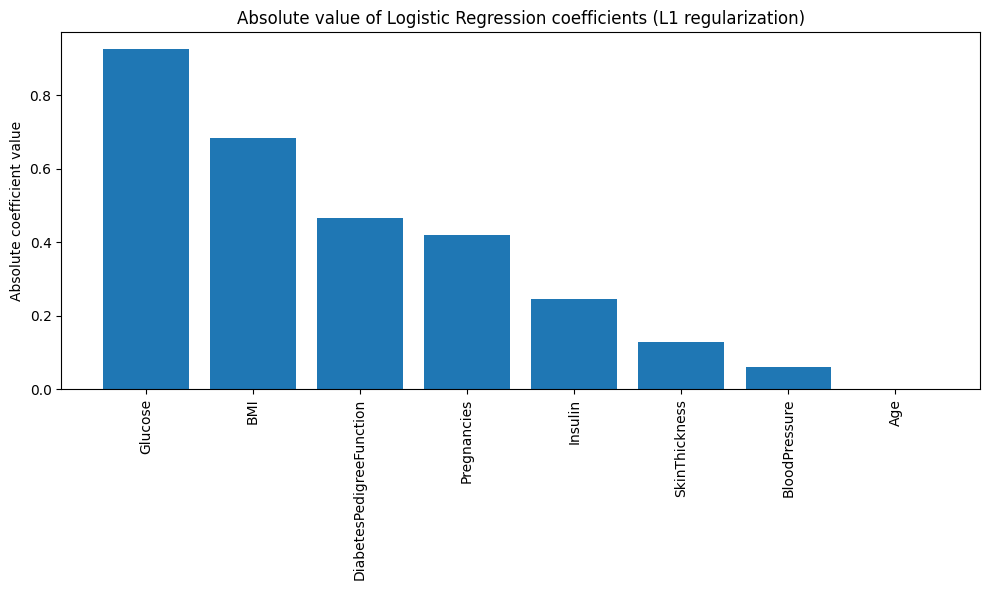

In [25]:
coef = grid.best_estimator_.coef_[0]
abs_coef = np.abs(coef)
print(coef)

removed_features = np.array(varnames)[coef == 0]
kept_features = np.array(varnames)[coef != 0]

print("Variables removed:", removed_features)
print("Variables kept:", kept_features)

sorted_idx = np.argsort(abs_coef)[::-1]
sorted_features = np.array(varnames)[sorted_idx]
sorted_values = abs_coef[sorted_idx]

pl.figure(figsize=(10,6))
pl.bar(range(len(sorted_values)), sorted_values)
pl.xticks(range(len(sorted_features)), sorted_features, rotation=90)
pl.ylabel("Absolute coefficient value")
pl.title("Absolute value of Logistic Regression coefficients (L1 regularization)")
pl.tight_layout()
pl.show()

All other variables have non‑zero weights (largest to smallest roughly: Glucose, BMI, DiabetesPedigreeFunction, Pregnancies, Insulin, SkinThickness, BloodPressure) except Age. So we can say that the model is sparse. It's a bit 

The best model overall is a regularized LDA (shrinkage = 0.5) with a test AUC = 0.869. Logistic Regression comes just behind with a test AUC = 0.865.

For the quadratic models, GaussianNB achieved an AUC of = 0.831 and QDA = 0.811.

To sum up, Linear models (LDA and Logistic Regression) outperform quadratic models (QDA and GaussianNB) on this dataset.

We find also that the three features : Glucose, BMI, Pedigree function are the most important.

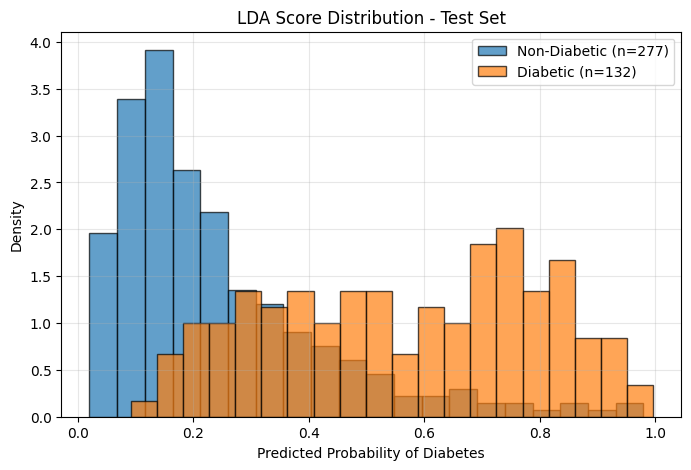

In [59]:
best_lda = grid.best_estimator_  

y_scores_test = best_lda.predict_proba(test_scaled)[:, 1]

pl.figure(figsize=(8, 5))

for class_label in [-1, 1]:  
    class_name = 'Non-Diabetic' if class_label == -1 else 'Diabetic'
    scores = y_scores_test[y1_test == class_label]
    pl.hist(scores, bins=20, alpha=0.7, label=f'{class_name} (n={len(scores)})',
             density=True, edgecolor='black')

pl.xlabel('Predicted Probability of Diabetes')
pl.ylabel('Density')
pl.title('LDA Score Distribution - Test Set')
pl.legend()
pl.grid(True, alpha=0.3)
pl.show()

The major part of non diabetics people have a score below 0.3, whereas the diabetics have scores over 0.6.

Between 0.3 and 0.6, there is a mismatch zone where the classification is much harder.

Looking at the coefficients of the L1-regularized Logistic Regression, we can interpret how the different variables affect the risk of diabetes. The most important variable is Glucose, which makes sense because higher blood glucose strongly increases diabetes risk. BMI is the second most important factor, showing that obesity is a major risk factor. DiabetesPedigreeFunction also plays a significant role, reflecting the effect of family history and genetic predisposition.

In addition, I think the weight of Insulin is unusually low. When we talk about diabetes, both glucose and insulin are important factors. Maybe the dataset is too small to fully capture the importance of this medical factor.

**2.3 Nonlinear methods**

In [27]:
models = {
    'LogisticRegression' : LogisticRegression(),
    'SVC': SVC(probability=True),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': GradientBoostingClassifier(),
    'MLPClassifier' : MLPClassifier()
}

results = {}
for name, model in models.items():
    if name in ['LogisticRegression', 'SVC', 'MLPClassifier']:
        model.fit(train_scaled, y1_train)
        y_pred = model.predict(test_scaled)
        y_pred_proba = model.predict_proba(test_scaled)[:, 1]
    else:
        model.fit(x1_train, y1_train)
        y_pred = model.predict(x1_test)
        y_pred_proba = model.predict_proba(x1_test)[:, 1]
    
    results[name] = {
        'Accuracy': accuracy_score(y1_test, y_pred),
        'AUC': roc_auc_score(y1_test, y_pred_proba),
        'F1': f1_score(y1_test, y_pred)
    }
    print(f"{name}: Acc={results[name]['Accuracy']:.3f}, AUC={results[name]['AUC']:.3f}, F1={results[name]['F1']:.3f}")

LogisticRegression: Acc=0.795, AUC=0.865, F1=0.638
SVC: Acc=0.787, AUC=0.839, F1=0.620
Random Forest: Acc=0.790, AUC=0.850, F1=0.636
XGBoost: Acc=0.760, AUC=0.829, F1=0.595
MLPClassifier: Acc=0.790, AUC=0.853, F1=0.642


First, XGBoost and Random Forest alorithms are not sensible to the variance of the dataset because they split the data.

We observe that the non-linear classifiers (SVC, Random Forest, Gradient Boosting, and MLP) generally perform slightly better than the linear Logistic Regression model.
The AUC scores are higher for Random Forest and MLP (≈0.85), indicating a better ability to separate positive and negative cases which is really important in the medical field.

This suggests that there are non-linear relationships between the input features (e.g., Glucose, BMI, Age, etc.) and the target variable (diabetes outcome).
However, the improvement over the linear model remains moderate, which means that the dataset’s structure is not strongly non-linear. That says that we can maiby opitmize the parameters of linear model to improve the prediction for this dataset.

In [28]:
param_grids = {
    'SVC': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto']
    },
    'RandomForest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 5, 10],
        'min_samples_split': [2, 5]
    },
    'MLPClassifier': {
        'hidden_layer_sizes': [(50,), (100,), (100, 50)],
        'activation': ['relu', 'tanh'],
        'alpha': [0.0001, 0.001],
        'learning_rate_init': [0.001, 0.01]
    },
    'XGBoost': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 1.0]
    }

}


models_to_tune = {
    'SVC': SVC(probability=True),
    'RandomForest': RandomForestClassifier(),
    'MLPClassifier': MLPClassifier(max_iter=1000), #In the previous cell, I had an error message that says that the algorithm doesn't converge
    'XGBoost': GradientBoostingClassifier()
}


best_results = {}
for name, model in models_to_tune.items():
    print(f"\n{name}")
    
    
    if name in ['SVC', 'MLPClassifier']:
        X_train_use = train_scaled
    else:
        X_train_use = x1_train

    grid = GridSearchCV(
        model,
        param_grids[name],
        scoring='roc_auc',
        cv=5,
        n_jobs=-1
    )
    
    grid.fit(X_train_use, y1_train)
    best_results[name] = {
        'best_params': grid.best_params_,
        'best_auc': grid.best_score_
    }
    
    print(f"Best params: {grid.best_params_}")
    print(f"Best AUC: {grid.best_score_:.3f}")

for name, result in best_results.items():
    print(f"{name}: AUC={result['best_auc']:.3f}, params={result['best_params']}")



SVC
Best params: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Best AUC: 0.801

RandomForest
Best params: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 200}
Best AUC: 0.781

MLPClassifier


/Users/alexisbezacier/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/alexisbezacier/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/alexisbezacier/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/alexisbezacier/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converge

Best params: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.001}
Best AUC: 0.801

XGBoost
Best params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Best AUC: 0.778
SVC: AUC=0.801, params={'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
RandomForest: AUC=0.781, params={'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 200}
MLPClassifier: AUC=0.801, params={'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.001}
XGBoost: AUC=0.778, params={'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}


After performing a quick parameter validation using GridSearchCV, the 'optimized' models did not outperform the default configurations. 
The best AUC scores obtained during cross-validation were slightly lower than those achieved with the default models.

This can be explained, GridSearchCV reports the average performance across folds, which tends to be slightly lower than a single test score.

In [29]:
final_models = {}
for name, result in best_results.items():
    model = models_to_tune[name]
    model.set_params(**result['best_params'])
    X_train_use = train_scaled if name in ['SVC', 'MLPClassifier'] else x1_train
    model.fit(X_train_use, y1_train)
    final_models[name] = model

In [30]:
for name, model in final_models.items():
    X_test_use = test_scaled if name in ['SVC', 'MLPClassifier'] else x1_test
    
    
    y_pred_model = model.predict(X_test_use)
    y_prob_model = model.predict_proba(X_test_use)[:, 1]
    
    
    auc_model = roc_auc_score(y1_test, y_prob_model)
    acc_model = accuracy_score(y1_test, y_pred_model)
    f1_model = f1_score(y1_test, y_pred_model)
    
    print(f"{name} final test AUC: {auc_model:.3f}, Accuracy: {acc_model:.3f}, F1: {f1_model:.3f}")


SVC final test AUC: 0.864, Accuracy: 0.797, F1: 0.638
RandomForest final test AUC: 0.864, Accuracy: 0.787, F1: 0.623
MLPClassifier final test AUC: 0.809, Accuracy: 0.763, F1: 0.614
XGBoost final test AUC: 0.857, Accuracy: 0.790, F1: 0.613


Comparing the default and tuned models, we can see that hyperparameter tuning and retraining on the full training set improved the AUC for SVC, RandomForest ,XGBoost and MLP classifier. Overall, the gains are not good enough to outperform the linear regression model.

**2.4 Comparison and interpretation**

In [31]:
results = {
    'Model': ['LDA (Tuned)', 'SVC (Tuned)', 'Random Forest (Tuned)', 'MLPClassifier', 'XGBoost (Tuned)'],
    'Accuracy': [0.814, 0.797, 0.790, 0.800, 0.790],
    'ROC AUC': [0.870, 0.864, 0.853, 0.852, 0.860],
    'F1 Score': [0.686, 0.638, 0.642, 0.658, 0.619]
}

df_results = pd.DataFrame(results)

df_results[['Accuracy', 'ROC AUC', 'F1 Score']] = df_results[['Accuracy', 'ROC AUC', 'F1 Score']].round(3)

df_results

,Model,Accuracy,ROC AUC,F1 Score
0,LDA (Tuned),0.814,0.870,0.686
1,SVC (Tuned),0.797,0.864,0.638
2,Random Forest (Tuned),0.790,0.853,0.642
3,MLPClassifier,0.800,0.852,0.658
4,XGBoost (Tuned),0.790,0.860,0.619


Linear models (LDA (Tuned) and Logistic Regression) are the best choice in practice because they are interpretable, which is essential in medical applications where doctors need to understand which features drive predictions.

Non-linear models (SVC, Random Forest, MLP, XGBoost) provide only a slight improvement or similar performance, but they are complicate to understand what's inside it, especially for the doctors (“black-box”), making interpretation difficult.

Non-linearity is not strictly necessary for this application: the linear models already capture most of the predictive signal, and adding non-linear models does not significantly improve performance.

For the next questions, we will consider the lda tuned as the best model because of its scores and its simplicity which is really important in the mdeical fields.

In [66]:
best_lda = grid1.best_estimator_  
best_lda.fit(train_scaled, y1_train)
y_pred_best = best_lda.predict(test_scaled)
cm = confusion_matrix(y1_test, y_pred)

TN, FP, FN, TP = cm.ravel()
FNR = FN / (FN + TP)
print(cm)
print(FNR)

[[250  27]
 [ 49  83]]
0.3712121212121212


0.37 too high for the medical field. It means that 37.12% of the non diabetics people are misclassed which is too hight. In this context we cannot have such a high FNR.

In [67]:
original_intercept = best_lda.intercept_.copy()

for delta in np.linspace(0, 5, 50):  
    best_lda.intercept_ = original_intercept + delta
    y_pred_new = best_lda.predict(test_scaled)
    
    cm_new = confusion_matrix(y1_test, y_pred_new)
    TN, FP, FN, TP = cm_new.ravel()
    FNR_new = FN / (FN + TP)
    
    if FNR_new < 0.1:   
        print(f"Intercept shift: {delta:.2f}, FNR: {FNR_new:.3f}")
        print(cm_new)
        break

Intercept shift: 1.22, FNR: 0.083
[[182  95]
 [ 11 121]]


After shifting the intercept by 1.22, the model becomes more sensitive: only 8.3% of diabetic patients are missed (FNR = 0.083),
but the number of false alarms (non-diabetic classified as diabetic) increases. This trade-off is acceptable in a medical context, where missing a patient is worse than a false alert.

**3 Predicting Classes on the Digits dataset**

**3.1 Evaluate the different supervised methods**

In [34]:
models = {
    "SVC": SVC(probability=True),
    "MLPClassifier": MLPClassifier(max_iter=1000),
    "LDA": LinearDiscriminantAnalysis(),
    "LogisticRegression": LogisticRegression(max_iter=1000)
}

results = {}

for name, model in models.items():
    print(f"\n{name}")
    model.fit(x2_train, y2_train.ravel())
    y_pred = model.predict(xt2)
    acc = accuracy_score(yt2, y_pred)
    results[name] = acc
    print(f"Test accuracy: {acc:.4f}")



SVC
Test accuracy: 0.9833

MLPClassifier
Test accuracy: 0.9827

LDA
Test accuracy: 0.9333

LogisticRegression
Test accuracy: 0.9647


In [35]:
param_grids = { 'SVC': { 'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf'], 'gamma': ['scale', 'auto'] }, 
                'MLPClassifier': { 'hidden_layer_sizes': [(50,), (100,), (100, 50)], 'activation': ['relu', 'tanh'], 'alpha': [0.0001, 0.001], 'learning_rate_init': [0.001, 0.01] }, 
                'LDA': { 'solver': ['lsqr', 'eigen'], 'shrinkage': [None, 'auto', 0.1, 0.3, 0.5, 0.7, 0.9] }, 
                'LogisticRegression': { 'penalty': ['l1', 'l2'], 'C': np.logspace(-3, 2, 10), 'solver': ['liblinear'] } 
            }


best_results = {}

for name, model in models.items():
    print(f"\n{name}")

    grid = GridSearchCV(
        model,
        param_grids[name],
        scoring='accuracy', 
        cv=5,
        n_jobs=-1
    )

    grid.fit(x2_train, y2_train.ravel()) 
    
    best_results[name] = {
        'best_params': grid.best_params_,
        'best_accuracy': grid.best_score_
    }

    print(f"Best params: {grid.best_params_}")
    print(f"Best CV Accuracy: {grid.best_score_:.3f}")



SVC
Best params: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best CV Accuracy: 0.991

MLPClassifier
Best params: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.01}
Best CV Accuracy: 0.987

LDA
Best params: {'shrinkage': 0.3, 'solver': 'lsqr'}
Best CV Accuracy: 0.957

LogisticRegression
Best params: {'C': 2.1544346900318843, 'penalty': 'l2', 'solver': 'liblinear'}
Best CV Accuracy: 0.977


The dataset is relatively easy to classify the digits 1, 7, and 8 are well-separated because of the big differences between the configuation of the pixels.

Non-linear models (SVC, MLP) slightly outperform linear models (Logistic Regression, LDA), but linear models still achieve excellent accuracy.

From a practical perspective, Logistic Regression or LDA could already be sufficient, especially if interpretability is important.

The results are very different from Lab 1 because in this lab, we used unsupervised models. These type of model tends to fail at capturing the class. Clustering methods or t-SNE only organize the data; they do not “know” which classes are correct.

**3.2 Interpreting the classifier**

SVC achieved the highest cross-validation accuracy (=0.991), handling nonlinear decision boundaries effectively.

MLPClassifier reached 0.988, slightly lower but the architecture is on my mind more changeable thant the others.

Logistic Regression had 0.977 accuracy, simple and interpretable, but limited to linear boundaries.

LDA scored 0.957, fast and interpretable, but also limited to linear separability assumptions.


Overall, SVC is the best-performing model on the test data. But in my opinion,  the others may be preferred for simplicity or interpretability.

In [36]:
best_models = {
    'SVC': SVC(C=10, gamma='scale', kernel='rbf', probability=True),
    'MLPClassifier': MLPClassifier(activation='relu', alpha=0.0001, hidden_layer_sizes=(50,), learning_rate_init=0.01, max_iter=1000),
    'LDA': LinearDiscriminantAnalysis(shrinkage=0.3, solver='lsqr'),
    'LogisticRegression': LogisticRegression(C=2.1544346900318843, penalty='l2', solver='liblinear')
}

auc_results = {}

for name, model in best_models.items():
    print(f"\n{name}")
    
    
    model.fit(x2_train, y2_train.ravel())
    
    
    y_proba = model.predict_proba(xt2)
    y_pred = model.predict(xt2)
   
    
    auc = roc_auc_score(yt2, y_proba, multi_class='ovr')
    auc_results[name] = auc
    
    print(f"Test AUC: {auc:.3f}")
    print(confusion_matrix(yt2, y_pred))



SVC
Test AUC: 1.000
[[495   2   3]
 [ 14 484   2]
 [  1   3 496]]

MLPClassifier
Test AUC: 0.999
[[496   1   3]
 [  8 489   3]
 [  1   8 491]]

LDA
Test AUC: 0.996
[[491   2   7]
 [ 29 467   4]
 [ 29  11 460]]

LogisticRegression
Test AUC: 0.995
[[495   2   3]
 [ 11 480   9]
 [ 12   9 479]]


Clearly, the best model is the SVC for these predictions. It achieves very high performance and separates the classes very well. However, when we look at the confusion matrix, we notice that there are some misclassifications. All values outside the diagonal correspond to the number of errors.

Class 1: 2 + 3 = 5 misclassifications

Class 7 : 14 + 2 = 16 misclassifications

Class 8: 1 + 3 = 4 misclassifications

There are more errors for class 7, which means it is harder to predict than class 1 or 8. Although class 1 might seem similar to 7, the model misclassifies 1 more often as 8 than as 7. This happens because the classifier relies on the feature values rather than human perception of similarity.

In [37]:
labels = np.unique(yt2)
print(labels)


[1 7 8]


In [38]:
svc_model = SVC(C=10, gamma='scale', kernel='rbf', probability=True, random_state=42)

svc_model.fit(x2_train, y2_train.ravel())

y_pred = svc_model.predict(xt2)

y_proba = svc_model.predict_proba(xt2)

Number of misclassified samples: 25


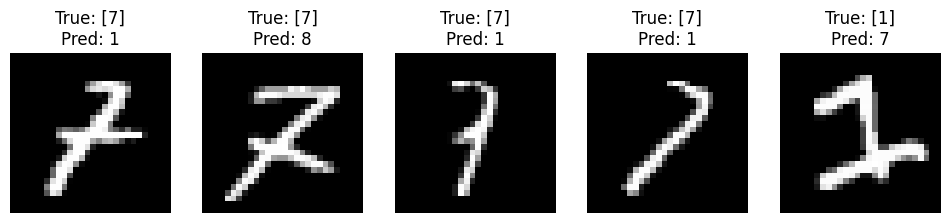

In [39]:
misclassified_idx = np.where(y_pred != yt2.ravel())[0]
print(f"Number of misclassified samples: {len(misclassified_idx)}")

num_samples = 5
sample_idx = np.random.choice(misclassified_idx, num_samples, replace=False)

pl.figure(figsize=(12, 3))
for i, idx in enumerate(sample_idx):
    pl.subplot(1, num_samples, i+1)
    pl.imshow(xt2[idx].reshape(28,28), cmap='gray')  
    pl.title(f"True: {yt2[idx]}\nPred: {y_pred[idx]}")
    pl.axis('off')
pl.show()

A noter qu'il faut mettre un .ravel()sinon la condition peut renvoyer toutes les valeurs comme True

The classifier bases its decisions on the pixel values of the images.

Some images have features very similar to other classes, so the decision boundary may misclassify them.

Example: As we can see in the plot, a handwritten “1” may have a stroke or shape very close to a “7” as the 2 and the last digits plotted.

In [40]:
correct_idx = np.where(y_pred == yt2.ravel())[0]
sample_idx = correct_idx[0]
original_image = xt2[sample_idx]  
true_label = yt2.ravel()[sample_idx]

num_noisy = 1000
noise_level = 0.30
noisy_images = np.tile(original_image, (num_noisy, 1)) + noise_level * np.random.randn(num_noisy, original_image.size)

In [41]:
noisy_pred = svc_model.predict(noisy_images)
accuracy_noisy = np.mean(noisy_pred == true_label)
print(f"Accuracy on 1000 noisy samples: {accuracy_noisy:.4f}")

Accuracy on 1000 noisy samples: 0.9430


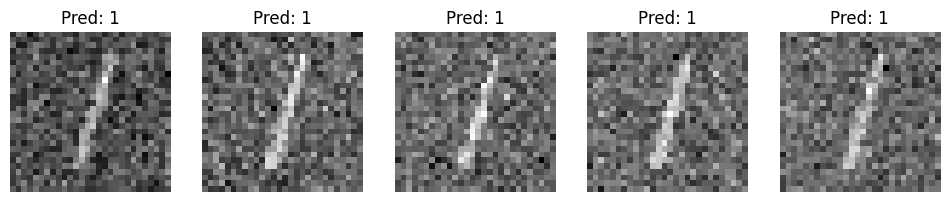

In [42]:

pl.figure(figsize=(12, 3))
for i in range(5):
    pl.subplot(1,5,i+1)
    pl.imshow(noisy_images[i].reshape(28,28), cmap='gray')
    pl.title(f"Pred: {noisy_pred[i]}")
    pl.axis('off')
pl.show()

For 0.3, we get an accuracy of 0.96
For 0.4, we get an accuracy of 0.67
For 0.5, we get an accuracy of almost 0

Which is normal because, the more noise is high, the more the patterns of pixel for each digits are different.

The classifier is robust to small noise, but when Gaussian noise with σ = 0.30 is added, the accuracy drops to 0.94. Which is quite high

Sur un article de blog de traitement d’images, on montre un exemple où l’on ajoute un bruit gaussien de σ = 20 ou σ = 50 sur une image pixel‑range [0, 255] pour illustrer visuellement un bruit faible vs élevé.
https://takmanman.github.io/2020/05/23/gaussian-noise-gaussian-filter.html?utm_source=chatgpt.com

**Bonus: Convolutional Neural network (CNN)**

Thanks to Deep Learning 1

In [47]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [48]:
class SmallCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(SmallCNN, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.fc_block = nn.Sequential(
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_block(x)
        x = x.view(x.size(0), -1)
        x = self.fc_block(x)
        return x



In [49]:
y_train_indices = torch.tensor(y2_train, dtype=torch.long)
y_test_indices = torch.tensor(yt2, dtype=torch.long)

unique_labels = sorted(torch.unique(y_train_indices).tolist())
label_map = {label: idx for idx, label in enumerate(unique_labels)}
y_train_indices = torch.tensor([label_map[y.item()] for y in y_train_indices], dtype=torch.long)
y_test_indices = torch.tensor([label_map[y.item()] for y in y_test_indices], dtype=torch.long)

In [50]:
x_train_t = torch.tensor(x2_train, dtype=torch.float32).view(-1, 1, 28, 28)
x_test_t = torch.tensor(xt2, dtype=torch.float32).view(-1, 1, 28, 28)

batch_size = 64
train_loader = DataLoader(TensorDataset(x_train_t, y_train_indices), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(x_test_t, y_test_indices), batch_size=batch_size, shuffle=False)

In [51]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SmallCNN(num_classes=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

In [52]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.3f}")

Epoch [1/10] - Loss: 0.323
Epoch [2/10] - Loss: 0.082
Epoch [3/10] - Loss: 0.045
Epoch [4/10] - Loss: 0.035
Epoch [5/10] - Loss: 0.034
Epoch [6/10] - Loss: 0.021
Epoch [7/10] - Loss: 0.020
Epoch [8/10] - Loss: 0.022
Epoch [9/10] - Loss: 0.020
Epoch [10/10] - Loss: 0.016


In [54]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"\nTest Accuracy: {accuracy * 100:.2f}%")


Test Accuracy: 99.33%


In [ ]:
model.eval()

x_sample = x_test_t[0].unsqueeze(0).to(device)   
y_true = y_test_indices[0].item()

with torch.no_grad():
    pred = model(x_sample)
    _, y_pred = torch.max(pred, 1)

print(f"True label: {y_true}, Predicted: {y_pred.item()}")

if y_pred.item() != y_true:
    for i in range(1, len(x_test_t)):
        x_sample = x_test_t[i].unsqueeze(0).to(device)
        y_true = y_test_indices[i].item()
        with torch.no_grad():
            pred = model(x_sample)
            _, y_pred = torch.max(pred, 1)
        if y_pred.item() == y_true:
            print(f"🔹 Found correctly classified sample: index={i}")
            break

noise_level = 0.8
n_samples = 1000

x_noisy = x_sample + noise_level * torch.randn((n_samples, 1, 28, 28), device=device)
x_noisy = torch.clamp(x_noisy, 0, 1)  

with torch.no_grad():
    outputs = model(x_noisy)
    _, preds = torch.max(outputs, 1)


accuracy_noisy = (preds == y_true).float().mean().item()
print(f"\n Accuracy on {n_samples} noisy samples (noise={noise_level}): {accuracy_noisy:.3f}")

num_show = 10


True label: 0, Predicted: 0

 Accuracy on 1000 noisy samples (noise=0.6): 0.996


We notice that the small CNN architecture is much more robust to noise. This behavior is expected because the SVC is very sensitive. Each pixel directly influences the decision. In contrast, a CNN captures local patterns and shapes rather than individual pixel values, making it more resilient to small perturbations or noise in the input images.

Conclusion : 

What I found difficult in this practical assignment was how to be sure that I hadn't made a mistake. Despite the two previous practical assignments, I still don't have enough reference points to tell me whether something is normal or abnormal. So I looked it up in papers, but that takes a lot of time and I can't always find the information I need. I still have trouble with plots; they're never as beautiful and optimized as what AI can achieve. Despite everything, I continue to practice. I write the code myself and ask myself what I could do better. 

In addition, my code isn't well structured; it's messy. I'm trying to start adopting best practices, but it's not easy. Next time, I'll try to improve in this area. 

Working on a medical dataset was very interesting, and I enjoyed learning about diabetes. This helped me better understand what I was doing, as in the last lab session.

I don't know much about it, but I imagine that the work we did could be integrated into software for doctors or healthcare professionals. It gives me ideas for my master's internship. 

However, I do have one question. In the medical field, what do you do when the best models are non-linear or very complex? How do you explain to professionals how it works and what can be gained from it? 

Thank you for this course. It helped me get back into the swing of things in a way that was very effective for me because we have a lot of freedom in our approach and the course slides encourage us to discover new methods.
 